In [1]:
#from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import sys, os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras

%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

(60000, 28, 28)


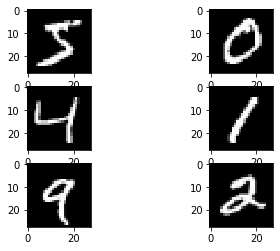

(60000, 784)
(10000, 784)
(60000, 28, 28)


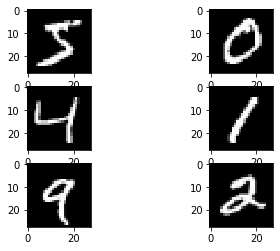

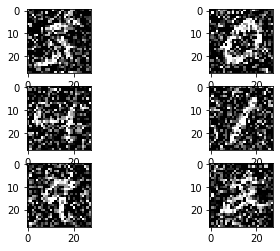

(60000, 784)
(10000, 784)


In [2]:
def load_mnist_dataset(path='mnist.npz'):
    #path = get_file(path, origin='https://s3.amazonaws.com/img-datasets/mnist.npz')
    f = np.load(path)
    x_train = f['x_train']
    y_train = f['y_train']
    x_test = f['x_test']
    y_test = f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)


# Visualizar 6 imagens do mnist numa escala de cinzentos
def visualize_mnist(X_train):
    #(X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    plt.subplot(321)
    plt.imshow(X_train[0], cmap='gray')
    plt.subplot(322)
    plt.imshow(X_train[1], cmap='gray')
    plt.subplot(323)
    plt.imshow(X_train[2], cmap='gray')
    plt.subplot(324)
    plt.imshow(X_train[3], cmap='gray')
    plt.subplot(325)
    plt.imshow(X_train[4], cmap='gray')
    plt.subplot(326)
    plt.imshow(X_train[5], cmap='gray')
    plt.show()
    
def data_preparation_2D():
    (X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    print(X_train.shape)
    
    visualize_mnist(X_train)
    
    # transformar para o formato [instancias][largura][altura][pixeis]
    print("shape[0]: ",X_train.shape[0])
    print("shape antes: ",X_train.shape)
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
    print("shape depois: ",X_train.shape)
    
    # normalizar os valores dos pixeis de 0-255 para 0-1
    X_train = X_train / 255
    X_test = X_test / 255
    
    # transformar o label que é um inteiro em categorias binárias, o valor passa a ser o correspondente à posição
    # o 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    num_classes = y_test.shape[1]
    
    return X_train, X_test, y_train, y_test, num_classes


def data_preparation_1D():
    (X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    print(X_train.shape)
    
    visualize_mnist(X_train)
    
    # transformar para o formato [instancias][largura * altura]
    X_train = X_train.astype('float32')/255
    X_test = X_test.astype('float32')/255
    
    num_pixels = X_train.shape[1] * X_train.shape[2] #ou np.prod(X_train.shape[1:])
    
    X_train = X_train.reshape(len(X_train), num_pixels) #para passar a matriz a vetor
    X_test = X_test.reshape(len(X_test), num_pixels)
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    num_classes = y_test.shape[1]
    
    print(X_train.shape)
    print(X_test.shape)
    
    return X_train, X_test, y_train, y_test, num_classes
    
    
#acrescentar ruido nas imagens
def data_preparation_1D_ruido():
    (X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    print(X_train.shape)
    
    visualize_mnist(X_train)
    
    # transformar para o formato [instancias][pixeis][largura][altura]
    X_train = X_train.astype('float32')/255
    X_test = X_test.astype('float32')/255
    
    num_pixels = X_train.shape[1] * X_train.shape[2] #ou np.prod(X_train.shape[1:])
    
    X_train = X_train.reshape(len(X_train), num_pixels) #faz o (28,28) = 784
    X_test = X_test.reshape(len(X_test), num_pixels)
    
    #somar ao X_tarin valores aleatorios com distribuição normal centro em 0 e largura 0.5
    X_train_ruido = X_train + np.random.normal(loc=0.0, scale=0.5, size=X_train.shape)
    X_train_ruido = np.clip(X_train_ruido, 0., 1.) #para podar os valores menores do que 0 e maiores do que 1

    X_test_ruido = X_test + np.random.normal(loc=0.0, scale=0.5, size=X_test.shape)
    X_test_ruido = np.clip(X_test_ruido, 0., 1.)
    
    visualize_mnist(X_train_ruido.reshape(len(X_train),28,28))
    
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    num_classes = y_test.shape[1]
    
    print(X_train.shape)
    print(X_test.shape)
    
    return X_train_ruido, X_test_ruido, y_train, y_test, num_classes
  
    
#X_train, X_test, y_train, y_test, num_classes = data_preparation_2D()
X_train, X_test, y_train, y_test, num_classes = data_preparation_1D()

#X_train, X_test, y_train, y_test, num_classes = data_preparation_2D()
X_train_ruido, X_test_ruido, y_train, y_test, num_classes = data_preparation_1D_ruido()

In [3]:
#função de ativação relu para não-linearidade e no final sigmoid pois quero a probabilidade de ser 1 ou 0

def create_Autoencoder():
    input_image= Input(shape=(784,))
    encoded1 = Dense(units=128, activation='relu')(input_image)
    encoded2 = Dense(units=64, activation='relu')(encoded1)
    encoded_final = Dense(units=32, activation='relu')(encoded2)
    decoded1 = Dense(units=64, activation='relu')(encoded_final)
    decoded2 = Dense(units=128, activation='relu')(decoded1)
    decoded_final = Dense(units=784, activation='sigmoid')(decoded2)
     
    encoder = Model(inputs=input_image, outputs=encoded_final) #só até gargalo na rede entre antes de entrar do decoder
    autoencoder = Model(inputs=input_image, outputs=decoded_final)
    return autoencoder, encoder

(autoencoder, encoder) = create_Autoencoder()
print("\n############### ENCODER #################")
encoder.summary()
print("\n############### ENCODER + DECODER #################")
autoencoder.summary()


############### ENCODER #################
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________

############### ENCODER + DECODER #################
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_

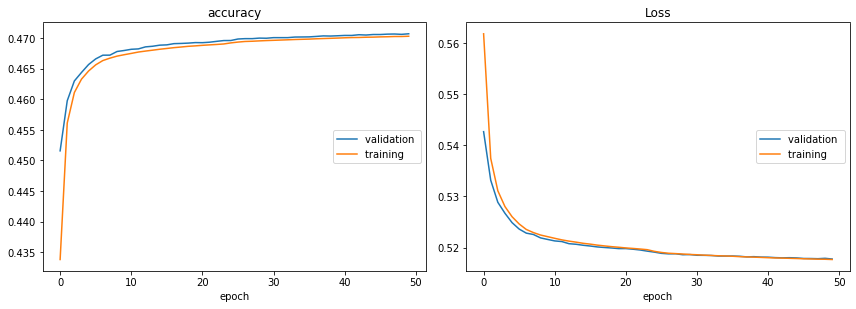

accuracy
	validation       	 (min:    0.452, max:    0.471, cur:    0.471)
	training         	 (min:    0.434, max:    0.470, cur:    0.470)
Loss
	validation       	 (min:    0.518, max:    0.543, cur:    0.518)
	training         	 (min:    0.518, max:    0.562, cur:    0.518)
Scores:  [0.5177679384231567, 0.47067514061927795]
Erro autoencoder: 52.93%


In [4]:
def compiletrain(autoencoder, X_train, X_test):
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)
    history = autoencoder.fit(X_train, X_train, 
                              epochs=50, 
                              batch_size=256, 
                              shuffle=True, 
                              validation_data=(X_test, X_test),
                              verbose=0,
                              callbacks=[PlotLossesKeras()])
    # Avaliação final com os casos de teste
    scores = autoencoder.evaluate(X_test, X_test, verbose=0)
    print('Scores: ', scores)
    print("Erro autoencoder: %.2f%%" % (100-scores[1]*100))  
    #autoencoder.load_weights('best_weights.hdf5')
    return autoencoder,history

#vamos treinar o modelo usando os digitos com ruído
(autoencoder,history)=compiletrain(autoencoder, X_train_ruido, X_test_ruido)

Original Images - first 10 images of X_test


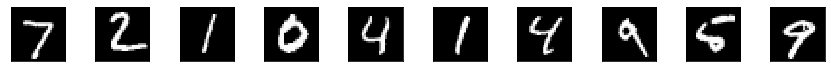

Original Images com ruído - first 10 images of X_test


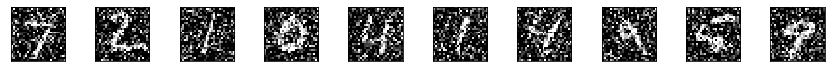

Encoded Images - first 10 images of X_test


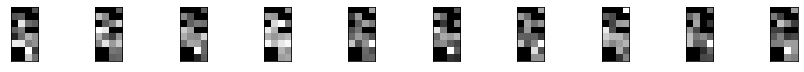

Decoded Images - first 10 images of X_test


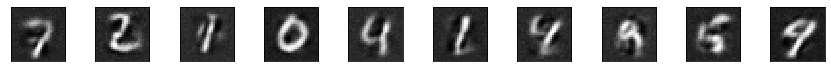

In [5]:
def visualize_predictions(encoder,autoencoder,X_test):
    encoded_images = encoder.predict(X_test_ruido)
    predicted_images = autoencoder.predict(X_test_ruido)
    
    # Original Images
    print("Original Images - first 10 images of X_test")
    plt.figure(figsize=(30, 1))
    for i in range(10):
        ax = plt.subplot(1, 20, i + 1)
        plt.imshow(X_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    # Original Images com ruído
    print("Original Images com ruído - first 10 images of X_test")
    plt.figure(figsize=(30, 1))
    for i in range(10):
        ax = plt.subplot(1, 20, i + 1)
        plt.imshow(X_test_ruido[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    # display Encoded Images  (latent space)
    print("Encoded Images - first 10 images of X_test")
    plt.figure(figsize=(30, 1))
    for i in range(10):
        ax = plt.subplot(1, 20, i + 1)
        plt.imshow(encoded_images[i].reshape(8,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show() 
    
    # display Decoded Images
    print("Decoded Images - first 10 images of X_test")
    plt.figure(figsize=(30, 1))
    for i in range(10):
        ax = plt.subplot(1, 20, i+ 1)
        plt.imshow(predicted_images[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
visualize_predictions(encoder,autoencoder,X_test)